In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import glob
import time
import json
import pandas as pd
import seaborn as sns

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

In [3]:
np.set_printoptions(suppress=True)
%matplotlib inline

In [4]:
# Print and save options
TEXT_WIDTH_PAPER = 7.22 #5.4 inches. 390pts OR 7.22 (from overleaf)- 7.48 inches (elsarticle doc) for double column
TEXT_HEIGHT_PAPER =  9.44 #7.6 inches 548.5 pts OR 9.44
SMALLER_SIZE = 8#8#14
SMALL_SIZE = 10#10#16
MEDIUM_SIZE = 12#12#18
BIGGER_SIZE = 14#22
BIGGEST_SIZE = 16#25

plt.rc('lines', linewidth=1.5)#3
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='normal')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Adjust below to switch to different types of image formats (bitmap or vector)
SAVE_EXT = '.pdf' # '.png' #.svg

In [5]:
def sort_by_noise(model):
    """
    Takes name of an experiment from the 'Adding biological constraints' project
    and returns all the models from that experiment, sorted increasingly by the standard deviation
    of the gaussian noise injection. 

    input:
    model: name of experiment

    output:
    numpy array of models
    """

    final_list = []
    noise_vals = []
    missing_files = []
    all_f = [direc for direc in glob.glob(os.path.join(os.getcwd(), model,'*')) if os.path.isdir(direc)] 
    for f in all_f:
        try:
            a = get_settings_from_file(os.path.join(f, 'params.json'))
        except:
            usr_select = input(f'File {f} is missing. Would you like to proceed without it? Enter y or n...')
            if usr_select in ['y','Y']:
                print('Continuing without file.')
                # all_f.remove(f)
                missing_files.append(f)
                continue
            elif usr_select in ['n','N']:
                print('Stopping.')
            else:
                raise ValueError('Please enter either y or n')
        else:
            if 'noise' not in a.keys():
                a['noise'] = None
            noise_vals.append(a['noise'])
            final_list.append(f)
            # print(f)
    
    if len(missing_files) > 0:
        for mf in missing_files:
            all_f.remove(mf)

    # print(all_f)
    assert all_f == final_list
    
    noise_vals = np.array(noise_vals)
    noise_vals[noise_vals==None] = 0.0
    # print(np.array(all_f)[np.argsort(noise_vals)])
    return np.array(all_f)[np.argsort(noise_vals)]
        
        


In [6]:
def get_settings_from_file(file):
    """
    Get settings for creating the model as recorded in

    a .json file. 
    """

    with open(file,'r') as f:
        settings = json.load(f)
    return settings

In [15]:
def get_results_from_model(model_names, col_list, model_type=None, logs_format='last'):
    """
    Get results from provided list of models given the parameters specified for extraction
    
    input:

    model_names - list of models to be extracted

    col_list - list of attributes to be recorded

    output:

    pandas dataframe with the results of every model in the specified experiments
    """

    assert type(model_names) == list
    assert type(col_list) == list
    assert logs_format in ['full', 'last']

    model_data = pd.DataFrame(columns=col_list)
    for model in model_names:

        all_files = sort_by_noise(model)
        
        for idx, model_dir in enumerate(all_files):

            data_holder = pd.DataFrame(columns=col_list)

            model_params = get_settings_from_file(os.path.join(model_dir,'params.json'))

            if model_type is not None:
                try:
                    logfile = '{m}_logs_sanity_{d}_10_classes_out.p'.format(
                        m=model_type, d=model_params['data'])
                except:
                    logfile = 'logs.p'

            else:
                logfile = 'logs.p'

            with open(os.path.join(model_dir,'logs',logfile), 'rb') as lf:

                log = pickle.load(lf)
                try:
                    acc = log.history['accuracy']
                except:
                    acc = log.history['acc']
                loss = log.history['loss']

                for column in data_holder:
                    if column in ['accuracy', 'acc', 'Accuracy']:
                        if logs_format=='last':
                            last_epoch_acc = np.asarray([acc[-1]])
                            data_holder[column] = last_epoch_acc
                        elif logs_format=='full':
                            data_holder[column] = acc
                    elif column in ['val_acc', 'val_accuracy', 'validation accuracy']:
                        val_acc = log.history['val_accuracy']
                        if logs_format=='last':
                            last_epoch_val_acc = np.asarray([val_acc[-1]])
                            data_holder[column] = last_epoch_val_acc
                        elif logs_format=='full':
                            data_holder[column] = val_acc
                    elif column in ['loss', 'Loss']:
                        if logs_format=='last':
                            last_epoch_loss = np.asarray([loss[-1]])
                            data_holder[column] = last_epoch_loss
                        elif logs_format=='full':
                            data_holder[column] = np.asarray(loss)
                    elif column in ['epoch','Epoch','epochs', 'Epochs'] and logs_format=='full':
                        data_holder[column] = np.arange(len(acc))
                    else:
                        if column == 'noise':
                            mul = len(acc) if logs_format == 'full' else 1
                            data_holder[column]= [np.round(model_params[column],2) if model_params[column] is not None else 0]*mul
                        else:
                            try:
                                data_holder[column] = model_params[column]
                            except:
                                print('No model parameter named {c} recorded in parameters file'.format(c=column))
                                break
                lf.close()

            model_data = model_data.append(data_holder, ignore_index=True)


    return model_data




In [8]:
def rewrite_params(dirs, column, value):
    """
    Correct or add a new dict entry in model parameters json file
    
    inputs:
    dirs - list of directories containing parameters file
    column - dict key which to add or modify
    value - value associated with key
    """

    assert type(column) == str
    assert type(value) in [str, int, float, list, bool]
    for fol in dirs:
        fil = os.path.join(fol, 'params.json')
        with open(fil,'r') as f:
            settings = json.load(f)
            f.close()
        settings[column] = value
        with open(fil, "w") as f:
            json.dump(settings, f)
        


In [9]:
def DrawChanceLine(x:list, y:list, plot_ax, colour=[0.5,0.5,0.5], style=':', label='Chance'):
    """
    Draws a line on the specified axis
    Returns: Nothing
    """
    plot_ax.plot(x, y, color=colour, ls=style, label=label)
    return

In [10]:
def hrz_line(*args, **kwargs):
    plt.axhline(color='k',linewidth=.4)


<h2>Main Capacity Constraints Figure, Full Dataset</h2>

<h3>Small inception</h3>

In [ ]:
#==============================================
#OLD. Use cell below instead                  #
#==============================================

all_models = ['inc-sanity-ncurve-cifar', 'inc-sanity-ncurve-rnd','inc-sanity-ncurvesig-cifar',
              'inc-sanity-ncurvesig-rnd', 'inc-sanity-ncurve-labels', 'inc-sanity-ncurvesig-labels',
              'inc-sanity-bncurve-cifar', 'inc-sanity-bncurve-rnd', 'inc-sanity-bncurve-labels',
              'inc-sanity-bncurvesig-cifar','inc-sanity-bncurvesig-rnd', 'inc-sanity-bncurvesig-labels']

n_bneck_models = 10
plot_type = 'Accuracy'
fig = plt.figure(figsize=(12.8,9.6))
num_reps = 4 
data = ['train']#,'test']
df = pd.DataFrame(columns=['noise','accuracy','Data type','activation','bottleneck'])#,'Dataset'])
print('neep')
for dat in data:
    for model in all_models:
        all_f = sort_by_noise(model)
        all_f = all_f[:100]

        logfile = 'inc_logs_sanity_{d}_10_classes_out.p'.format(d='cifar' if 'cifar' in model else 'rnd-gauss' if 'rnd' in model else 'rnd-labels')
        # print('got here')
        for idx, file in enumerate(all_f):
            data_holder = pd.DataFrame(columns=['noise','accuracy','Data type','activation','bottleneck'])#,'Dataset'])
            # print(file)
            with open(os.path.join(file,'logs',logfile),'rb') as fl:
                s_time = time.time()
                f = pickle.load(fl)
                try:
                    q = f.history['accuracy' if dat=='train' else 'val_accuracy'] 
                except:
                    q = f.history['acc' if dat=='train' else 'val_acc']
                p = f.history['loss' if dat=='train' else 'val_loss']

                settings = get_settings_from_file(os.path.join(file, 'params.json'))
                if settings['noise'] is not None and settings['noise']>1.01:
                    continue
                data_holder['noise']= [np.round(settings['noise'],2) if settings['noise'] is not None else 0]
                data_holder['accuracy'] = np.asarray(q)[-1]
                data_holder['bottleneck'] = settings['bottleneck']
                data_holder['activation'] = 'sigmoid' if 'sig' in model else 'relu'
                data_holder['Data type'] = 'cifar' if 'cifar' in model else 'random pixels' if 'rnd' in model else 'random labels'
                # data_holder['Dataset'] = dat

                fl.close()
                
            df = df.append(data_holder, ignore_index=True)




In [29]:
all_models = ['inc-sanity-ncurve-cifar', 'inc-sanity-ncurve-rnd','inc-sanity-ncurvesig-cifar',
              'inc-sanity-ncurvesig-rnd', 'inc-sanity-ncurve-labels', 'inc-sanity-ncurvesig-labels',
              'inc-sanity-bncurve-cifar', 'inc-sanity-bncurve-rnd', 'inc-sanity-bncurve-labels',
              'inc-sanity-bncurvesig-cifar','inc-sanity-bncurvesig-rnd', 'inc-sanity-bncurvesig-labels']
params = ['accuracy', 'noise', 'data', 'activation', 'bottleneck']

df = get_results_from_model(model_names=all_models, col_list=params, model_type='inc')
df = df.rename(columns={'data':'Data type'})
df = df[df['noise']<1.0]

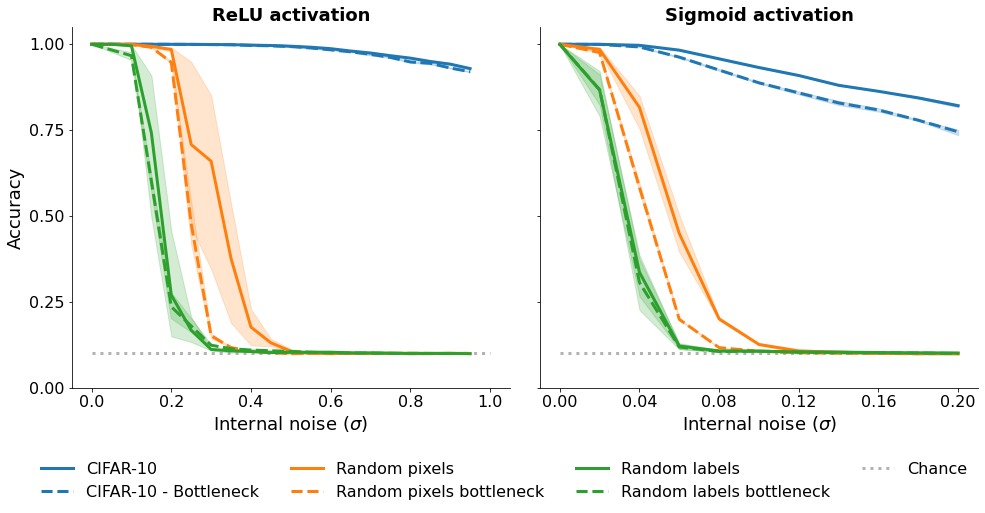

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(14, 7)

first = sns.lineplot(x='noise', y='accuracy', hue='Data type', style='bottleneck',
                     data=df[df['activation'] == 'relu'], ax=ax[0], legend='full')#,style='Dataset'
chanceline = ax[0].plot([0, 1],[0.1, 0.1], c=[0.5, 0.5, 0.5], linestyle=':',
                        alpha=0.6, label='Chance', zorder=1)

handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:-4]+[handles[-1]]
labels = labels[1:-4]+[labels[-1]]
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[2].get_c(), lw=handles[2].get_lw(), ls='--')]
handles = [x for pair in zip(handles, custom_lines) for x in pair]+[handles[-1]]
handles.append(chanceline)
labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck','Chance']

first.legend_.remove()
# print(handles,labels)
plt.tight_layout()
lgd = plt.legend(handles=handles, labels=labels , bbox_to_anchor=(0.5, 0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4)

sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck', data=df[df['activation']=='sigmoid'],ax=ax[1],legend=False)

ax[1].axes.set_xticks(np.linspace(0, 0.2, 6))
ax[0].set_ylim(0, 1.05)
ax[0].axes.set_yticks(np.linspace(0, 1, 5))

ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Internal noise '+r'$(\sigma)$')
ax[1].set_xlabel('Internal noise '+r'$(\sigma)$')

ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

ax[1].plot([0, 0.2], [0.1, 0.1], c=[0.5, 0.5, 0.5], linestyle=':', alpha=0.6, zorder=1)

sns.despine()

fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'constraints_only_train_bneck_{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


<h3>Small alexnet</h3>

In [39]:
all_models = ['alx-ncurve-cifar', 'alx-ncurve-rnd', 'alx-ncurvesig-labels',
              'alx-ncurvesig-cifar', 'alx-ncurvesig-rnd', 'alx-ncurve-labels', 
              'alx-bncurve-cifar', 'alx-bncurve-rnd', 'alx-bncurve-labels',
              'alx-bncurvesig-cifar', 'alx-bncurvesig-rnd', 'alx-bncurvesig-labels']
params = ['accuracy', 'noise', 'data', 'activation', 'bottleneck']

df = get_results_from_model(model_names=all_models, col_list=params, model_type='alx')
df = df.rename(columns={'data':'Data type'})

[<matplotlib.lines.Line2D object at 0x7f30426eb850>, <matplotlib.lines.Line2D object at 0x7f304269ef90>, <matplotlib.lines.Line2D object at 0x7f30426ebd50>, <matplotlib.lines.Line2D object at 0x7f3042499550>, <matplotlib.lines.Line2D object at 0x7f30426d2250>, <matplotlib.lines.Line2D object at 0x7f304060ed50>, <matplotlib.lines.Line2D object at 0x7f304269ec50>, [<matplotlib.lines.Line2D object at 0x7f304269ec50>]] ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck', 'Chance']


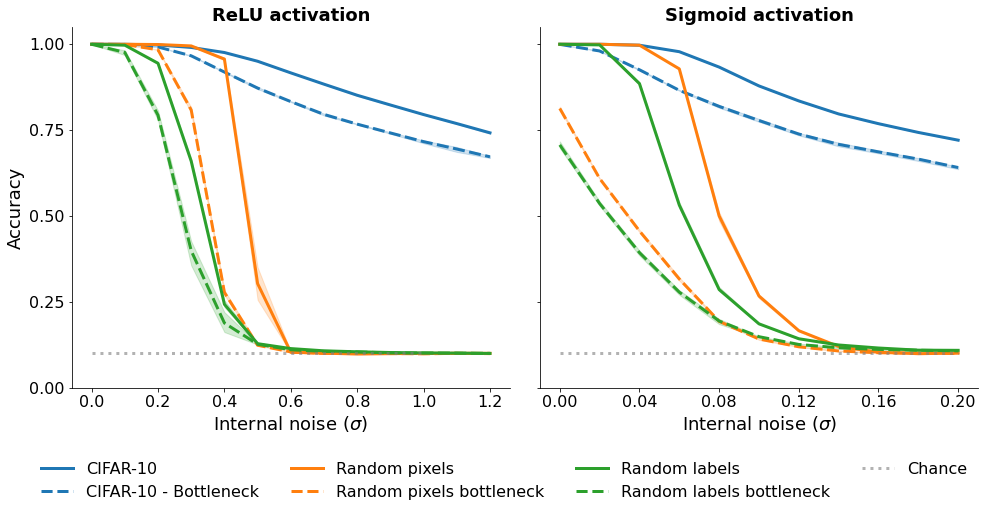

In [40]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(14, 7)
first = sns.lineplot(x='noise',y='accuracy',hue='Data type', style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='relu'],ax=ax[0],legend='full')#,style='Dataset'
chanceline = ax[0].plot([0,1],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,label='Chance')

handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:-4]+[handles[-1]]
labels = labels[1:-4]+[labels[-1]]
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[2].get_c(), lw=handles[2].get_lw(), ls='--')]
# labels.append('Chance')
handles = [x for pair in zip(handles, custom_lines) for x in pair]+[handles[-1]]#[handles[0], custom_lines[0], handles[1], custom_lines[1], handles[2]]
handles.append(chanceline)
labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck','Chance']

first.legend_.remove()
print(handles,labels)
plt.tight_layout()
plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4)#bbox_to_anchor=(1., 0.5), loc='center left')

lgd = sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='sigmoid'],ax=ax[1],legend=False)

ax[1].axes.set_xticks(np.linspace(0,0.2,6))
ax[0].set_ylim(0,1.05)
ax[0].axes.set_yticks(np.linspace(0,1,5))

ax[0].set_ylabel('Accuracy')
# ax[1].set_ylabel('Sigmoid\n\nAccuracy')
ax[0].set_xlabel('Internal noise '+r'$(\sigma)$')
ax[1].set_xlabel('Internal noise '+r'$(\sigma)$')

ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

sns.despine()

# chance =  [Line2D([0], [0], color='b', lw=4, label='Line')
ax[1].plot([0,0.2],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,)

fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'constraints_only_train_bneck_alx{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


<h2>Plot pixel-level genralisation in random pixel image datasets</h2>

In [75]:
# plot pixel generalization
model_n = 'alx'
act = '-new'
all_models = [f'{model_n}-pixel-gen', f'{model_n}-pixel-gen-sig']#['alx-capacity-full']
plot_type = 'Accuracy'
# fig, ax = plt.subplots()
# fig.set_size_inches(8,6)
noise = [0.0, 0.1,0.2,0.3]
df = pd.DataFrame(columns=['Changed pixels', 'Noise', 'Accuracy', 'Consistency', 'Unmodified acc', 'Activation'])
for model in all_models:

    folders = [direc for direc in glob.glob(os.path.join(os.getcwd(),
        model,'*')) if os.path.isdir(direc)]
    folders.sort()
    logfile = 'logs.p'
    folders_sorted = sort_by_noise(model)
    # print(folders_sorted)
    acc_total = {"0": np.empty((0,)), "0.3": np.empty((0,)), "0.6": np.empty((0,))}
    for folder in folders_sorted:
        for n in noise:
            config_f = get_settings_from_file(os.path.join(folder, 'params.json'))
            data = np.load(os.path.join(folder, 'mod_pixels_{}_100_samples.npz'.format(n)))
            acc = data['acc_labels']
            consist = data['acc']
            df_holder = pd.DataFrame({'Changed pixels': n, 'Noise': config_f['noise'],
                                      'Accuracy': acc, 'Consistency': consist,
                                      'Activation': config_f['activation']})
            df = df.append(df_holder, ignore_index=True)



In [76]:


df = df[df['Noise'].eq(0)]
df['Activation'] = df['Activation'].map({'relu':'ReLU', 'sigmoid':'Sigmoid'})


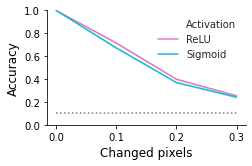

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches((1/2)*TEXT_WIDTH_PAPER,(1/4)*TEXT_HEIGHT_PAPER)
sns.set_style('white')

# sns.catplot(kind='bar',x='Noise',y='Accuracy',hue='Changed pixels',data=df,palette=sns.color_palette('Blues')[1:])
sns.lineplot(x='Changed pixels',y='Accuracy',hue='Activation', data=df, ax=ax, palette=[sns.color_palette()[6], sns.color_palette()[9]])
            #  palette=sns.color_palette("YlOrBr", n_colors=2), ax=ax)

# sns.barplot(x='Changed pixels', y='Accuracy', hue='Activation', data=df, ax=ax)
# ax.xaxis.label.set_size(14)
# ax.yaxis.label.set_size(14)
# ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()
ax.set_xticks(np.arange(0,0.31,0.1))
ax.set_ylim(0,1)
DrawChanceLine([0.0,0.3 ],[0.1,0.1], ax)
sns.despine()
plt.savefig(os.path.join(os.getcwd(), f'pixel_generalization_{model_n}_by_act_SMALLER_{SAVE_EXT}'))


<h2>Capacity plots</h2>

In [91]:
model_name = 'inc'#'alx'
all_models = [f'{model_name}-capacity-len_adj/n_2_x_10',f'{model_name}-capacity-len_adj/n_10_x_10',f'{model_name}-capacity-len_adj/n_10_x_100']#, \
    #  'inc-capacity-new/n_10_x_500']
df = pd.DataFrame(columns=['noise','accuracy','Data type','activation','bottleneck','N Classes', 'N examples','n_epochs'])#, 'loss', 'epochs'])#,'Dataset'])
for model in all_models:

    all_f = sort_by_noise(model)

    for idx, file in enumerate(all_f):
        data_holder = pd.DataFrame(columns=['noise','accuracy','Data type','activation','bottleneck','N Classes', 'N examples','n_epochs'])#, 'loss', 'epochs'])#,'Dataset'])
        settings = get_settings_from_file(os.path.join(file, 'params.json'))
        logfile = 'logs.p'
        with open(os.path.join(file,'logs',logfile),'rb') as fl:
            s_time = time.time()
            f = pickle.load(fl)
            try:
                q = f.history['accuracy'] 
            except:
                q = f.history['acc']
            p = f.history['loss']
            # print(len(p))
            # data_holder['loss'] = np.asarray(p[-50:])
            # data_holder['epochs'] = np.arange(50)
            if settings['num_classes']==2 and settings['epochs']!=2500:
                if (settings['activation']=='relu' and (settings['noise'] < 1. or settings['noise'] is None)) or \
                (settings['activation']== 'sigmoid' and (settings['noise'] < 0.2)):
                    if settings['bottleneck'] == False:
                        data_holder['noise']= [np.round(settings['noise'],2) if settings['noise'] is not None else 0]#*50
                        data_holder['accuracy'] = np.asarray(q)[-1]
                        data_holder['bottleneck'] = settings['bottleneck']
                        data_holder['activation'] = settings['activation']
                        data_holder['Data type'] = settings['data']
                        data_holder['N Classes'] = settings['num_classes']
                        data_holder['N examples'] = settings['num_per_class']
                        data_holder['n_epochs'] = settings['epochs']
                else:
                    continue
            else:
                data_holder['noise']= [np.round(settings['noise'],2) if settings['noise'] is not None else 0]#*50
                data_holder['accuracy'] = np.asarray(q)[-1]
                data_holder['bottleneck'] = settings['bottleneck']
                data_holder['activation'] = settings['activation']
                data_holder['Data type'] = settings['data']
                data_holder['N Classes'] = settings['num_classes']
                data_holder['N examples'] = settings['num_per_class']
                data_holder['n_epochs'] = settings['epochs']

            fl.close()

        df = df.append(data_holder, ignore_index=True)

In [92]:
cap_df = df.copy()
# Limiting plot to only look at 100 examples per class
cap_df = cap_df[cap_df['N examples'].eq(100)]
cap_df_sig = cap_df[(cap_df['noise'] <= 0.2) & (cap_df['activation'].eq('sigmoid'))]
cap_df_relu = cap_df[(cap_df['noise'] <= 1.0) & (cap_df['activation'].eq('relu'))]

In [93]:
# model_name = 'alx'#'alx'
prefix = '-sanity' if model_name == 'inc' else ''
all_models = [f'{model_name}{prefix}-ncurve-cifar', f'{model_name}{prefix}-ncurve-rnd',
              f'{model_name}{prefix}-ncurvesig-cifar', f'{model_name}{prefix}-ncurvesig-rnd',
              f'{model_name}{prefix}-ncurve-labels', f'{model_name}{prefix}-ncurvesig-labels',
              f'{model_name}{prefix}-bncurve-cifar', f'{model_name}{prefix}-bncurve-rnd',
              f'{model_name}{prefix}-bncurve-labels', f'{model_name}{prefix}-bncurvesig-cifar',
              f'{model_name}{prefix}-bncurvesig-rnd', f'{model_name}{prefix}-bncurvesig-labels']
params = ['accuracy', 'noise', 'data', 'activation', 'bottleneck']

df = get_results_from_model(model_names=all_models, col_list=params, model_type=model_name)
df = df.rename(columns={'data':'Data type'})
df = df[df['noise'] <= 1.0]


/home/gx19122/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/gx19122/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


CPU times: user 6.18 s, sys: 32 ms, total: 6.22 s
Wall time: 6.19 s


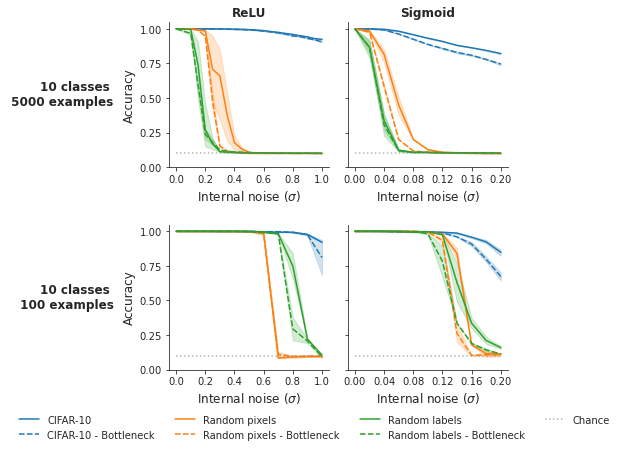

In [94]:
%%time
#Smaller version of plot above with only 10x100 and 10x5000 examples

fig, ax = plt.subplots(nrows=2,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER,(2/3)*TEXT_HEIGHT_PAPER) # 14, 12
legend = None
model_n = 'alxexnet' if 'alx' in model else 'inception'
conds = [(10,100)]
sns.lineplot(ax=ax[1, 0], x='noise', y='accuracy', hue='Data type', style='bottleneck',
             hue_order=['cifar', 'rnd-gauss', 'rnd-labels'],
             data=cap_df_relu[cap_df['N Classes'] == conds[0][0]][cap_df['N examples']==conds[0][1]],
             legend='full')
sns.lineplot(ax=ax[1, 1], x='noise', y='accuracy', hue='Data type', style='bottleneck',
             hue_order=['cifar', 'rnd-gauss', 'rnd-labels'],
             data=cap_df_sig[cap_df['N Classes'] == conds[0][0]][cap_df['N examples']==conds[0][1]],
             legend=legend)

sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck',
             hue_order=['cifar', 'rnd-gauss', 'rnd-labels'],
             data=df[df['activation']=='relu'], ax=ax[0,0],legend=False)
sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck',
             hue_order=['cifar', 'rnd-gauss', 'rnd-labels'],
             data=df[df['activation']=='sigmoid'],ax=ax[0,1],legend=False)


ax[0,1].title.set_text('Sigmoid')
ax[0,0].title.set_text('ReLU')


for curr_ax in ax.flatten():
    curr_ax.set_xlabel(r'Internal noise ($\sigma$)')


# Adapted from
# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5

rows = ['10 classes \n 5000 examples', '10 classes \n 100 examples']

annts = []
count = 0
for axis, row in zip(ax[:,0], rows):
    annts.append(axis.annotate(row, xy=(0, 0.5), xytext=(- axis.yaxis.labelpad - pad, 0),
                  xycoords=axis.yaxis.label, textcoords='offset points',
                  size=MEDIUM_SIZE, ha='right', va='center',
                  fontweight='bold'))
    count += 1

plt.tight_layout()

chanceline = ax[0,0].plot([0,1],[0.1, 0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,label='Chance')


handles, labels = ax[1,0].get_legend_handles_labels()

handles = handles[1:-3] 
labels = labels[1:-3] 
assert len(handles)==len(labels)

custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[2].get_c(), lw=handles[2].get_lw(), ls='--')]
# labels.append('Chance')
handles = [x for pair in zip(handles, custom_lines) for x in pair] #+ [handles[-1]]#[handles[0], custom_lines[0], handles[1], custom_lines[1], handles[2]]
labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels - Bottleneck', 'Random labels', 'Random labels - Bottleneck', 'Chance']

handles.append(chanceline[0])

ax[1,0].legend_.remove()
plt.tight_layout()
ax[1,0].plot([0,1],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6)
ax[0,1].plot([0,0.2],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6)
ax[1,1].plot([0,0.2],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6)

first_col_indices = [(0,0),(1,0)]
for first_col_idx in first_col_indices:
    ax[first_col_idx].set_ylabel('Accuracy')
    ax[first_col_idx].set_xticks(np.linspace(0,1., 6))

for curr_ax in ax.flatten():
    curr_ax.axes.set_yticks(np.linspace(0,1,5))


ax[0, 1].set_xticks(np.linspace(0,0.2, 6))
ax[1, 1].set_xticks(np.linspace(0,0.2, 6))


for a in fig.axes:
    a.tick_params(
    axis='both',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=True,
    top=False,
    left=True,
    labelbottom=True)

sns.despine()

# plt.subplots_adjust(bottom=0.9)

lgd = plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.6, 0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4, frameon=False)

fig.subplots_adjust(bottom=0.175, hspace=0.4)

plt.savefig(os.path.join(os.getcwd(), f'capacity_{model_n}_100_5k_legend_bot_annotated_SMALL{SAVE_EXT}'),
             bbox_extra_artists=(lgd, annts[0], annts[1]), bbox_inches='tight')


<h2>Genaralisation to degraded images</h2>

In [65]:
model_name = ['inc']
gen_type = ['noisy']
noise_type = ['uniform', 'salt_pep']
activation = ['', 'sig']
bneck = ['','b']
noise_min, noise_max, noise_step = (0, 0.5, 0.05)
noise_range = np.arange(noise_min, noise_max, noise_step) 
savedir = os.path.join(os.getcwd(),'json files','updated')

df = pd.DataFrame(columns=['Model', 'Degradation type', 'Activation', 'Bottleneck', 'Input Noise', 'Accuracy', 'Internal Noise'])
noise_range = np.round(np.arange(0,0.51,0.05),2)

for model in model_name:
    for act in activation:
        for bn in bneck:
            for gen in gen_type:
                for this_noise in noise_type:
                    prefix = '-sanity' if model=='inc' else ''
                     
                    for n in noise_range:

                        data = get_settings_from_file(os.path.join(
                            savedir,
                            f'{model}{prefix}-{bn}ncurve{act}-cifar_{gen}_{this_noise}_{n}_test.json'))
                        for k,v in data.items():
                            df_hold = pd.DataFrame(columns=['Model', 'Degradation type', 'Activation', 'Bottleneck', 'Input Noise', 'Accuracy', 'Internal Noise'])
                            df_hold['Accuracy'] = np.array(v)[:,1]     
                            df_hold['Model'] = model
                            df_hold['Degradation type'] = 'Uniform' if this_noise == 'uniform' else 'Salt and pepper'
                            df_hold['Activation'] = 'Sigmoid' if act else 'ReLU'
                            df_hold['Bottleneck'] = 'Yes' if bn else 'No'
                            df_hold['Input Noise'] = n
                            df_hold['Internal Noise'] = float(k)
                            df = df.append(df_hold, ignore_index=True)

                            


In [67]:
# Select data for inset
# df_smaller = df[np.logical_and(df['Input Noise']>=0, df['Input Noise']<0.3)]
df_smaller = df.loc[(df['Input Noise'] >= 0) & (df['Input Noise'] <= 0.2)]
diff_dict = {'diff_acc':[],'activation':[],'input noise':[], 'bottleneck':[], 'simulation':[]}
for sim in ['Uniform', 'Salt and pepper']:
    for act in ['ReLU', 'Sigmoid']:
        if model_name == 'alx':
            int_noise = [0.0, 0.6] if act=='ReLU' else [0.0, 0.16]
        else:
            int_noise = [0.0, 0.5] if act=='ReLU' else [0.0, 0.12]
        for bneck in ['Yes', 'No']:
            for input_n in df_smaller['Input Noise'].unique():
                act_filter = df_smaller['Activation'].eq(act)
                input_n_filter = df_smaller['Input Noise'].eq(input_n)
                bneck_filter = df_smaller['Bottleneck'].eq(bneck)
                sim_filter = df_smaller['Degradation type'].eq(sim)
                diff_array = df_smaller.loc[(act_filter) &
                                        (input_n_filter) &
                                        (bneck_filter) &
                                        (sim_filter) &
                                        df_smaller['Internal Noise'].eq(int_noise[1])
                                        ]['Accuracy'].to_numpy()\
                             - df_smaller.loc[(act_filter) &
                             (input_n_filter) &
                             (bneck_filter) &
                             (sim_filter) &
                             df_smaller['Internal Noise'].eq(int_noise[0])
                             ]['Accuracy'].to_numpy()

                # diff_array = df_smaller[df_smaller['Activation']==act][df_smaller['Input Noise']==input_n][df_smaller['Internal Noise']==int_noise[1]][df_smaller['Bottleneck']==bneck][df_smaller['Degradation type']==sim]['Accuracy'].to_numpy() - df_smaller[df_smaller['Activation']==act][df_smaller['Input Noise']==input_n][df_smaller['Internal Noise']==int_noise[0]][df_smaller['Bottleneck']==bneck][df_smaller['Degradation type']==sim]['Accuracy'].to_numpy()
                for diff in diff_array:
                    diff_dict['diff_acc'].append(diff)
                    diff_dict['activation'].append(act)
                    diff_dict['input noise'].append(input_n)
                    diff_dict['bottleneck'].append(bneck)
                    diff_dict['simulation'].append(sim)

In [68]:
df_diff = pd.DataFrame(diff_dict)

['Activation', 'ReLU', 'Sigmoid', 'Internal Noise', '0.0', '0.12', '0.5']


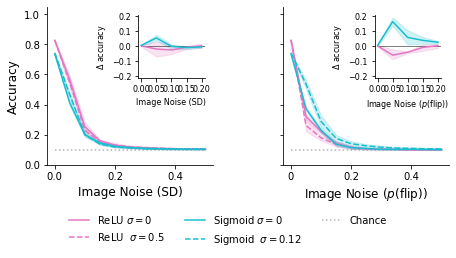

In [74]:
#COPY FROM ABOVE
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True, subplot_kw={'aspect':1/2})
fig.set_size_inches(TEXT_WIDTH_PAPER,TEXT_WIDTH_PAPER/2) #(14, 7)
colour_set = [sns.color_palette()[6], sns.color_palette()[9]]
bottleneck = 'Yes' #'No'
is_bneck = 'bneck' if bottleneck == 'Yes' else ''

filter_sig = df['Activation'].eq('Sigmoid')
filter_relu = df['Activation'].eq('ReLU')
if model_name == 'alx':
    filter_noise_range = [filter_sig & df['Internal Noise'].isin([0.0, 0.16]),
                          filter_relu & df['Internal Noise'].isin([0.0, 0.6])]
else:
    filter_noise_range = [filter_sig & df['Internal Noise'].isin([0.0, 0.12]),
                          filter_relu & df['Internal Noise'].isin([0.0, 0.5])]
    
filter_choices = [1,2]
df['Noise filtered'] = np.select(filter_noise_range, filter_choices)


sns.lineplot(x='Input Noise', y='Accuracy', hue='Activation', style='Internal Noise', ax=ax[0], \
     data=df[(df['Degradation type']=='Uniform') & (df['Bottleneck'].eq(bottleneck)) &
     (df['Noise filtered'].isin([1,2]))], palette=colour_set) 

sns.lineplot(x='Input Noise', y='Accuracy', hue='Activation', style='Internal Noise', ax=ax[1], \
    data=df[(df['Degradation type']=='Salt and pepper') & (df['Noise filtered'].isin([1,2])) & (df['Bottleneck']==bottleneck)],
    palette=colour_set)

chanceline = ax[0].plot([0,0.5],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6, zorder=1)
ax[1].plot([0,0.5],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6, zorder=1)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

axin1 = ax[0].inset_axes([0.55, 0.55, 0.4, 0.4])
sns.lineplot(ax=axin1,x='input noise', y='diff_acc', hue='activation',
             data=df_diff[(df_diff['simulation']=='Uniform') & (df_diff['bottleneck']==bottleneck)],
             palette=colour_set,legend=False)
axin1.set_xlim(-0.01, 0.21)
axin1.set_ylim(-0.21, 0.21)
axin1.plot([0, 1], [0, 0], c='k', lw=.5, zorder=1)
axin1.set_yticks(np.linspace(-0.2, 0.2, 5))
axin1.set_ylabel(r'$\Delta$ accuracy', fontsize=SMALLER_SIZE)
axin1.set_xticks(np.linspace(0, 0.2, 5))#([0, 0.1, 0.2, 0.25])#
axin1.set_xlabel(r'Image Noise (SD)', fontsize=SMALLER_SIZE)
axin1.spines['right'].set_visible(False)
axin1.spines['top'].set_visible(False)
axin1.tick_params(axis='both', which='major', labelsize=SMALLER_SIZE)


axin2 = ax[1].inset_axes([0.55, 0.55, 0.4, 0.4])
sns.lineplot(ax=axin2, x='input noise', y='diff_acc', hue='activation',
             data=df_diff[(df_diff['simulation']=='Salt and pepper') & (df_diff['bottleneck']==bottleneck)],
             palette=colour_set, legend=False)
axin2.set_xlim(-0.01, 0.21)
axin2.set_ylim(-0.21, 0.21)
axin2.plot([0, 1], [0, 0], c='k', lw=.5, zorder=1)
axin2.set_yticks(np.linspace(-0.2, 0.2, 5))
axin2.set_ylabel(r'$\Delta$ accuracy', fontsize=SMALLER_SIZE)
axin2.set_xticks(np.linspace(0, 0.2, 5))
axin2.set_xlabel(r'Image Noise ($p(\mathrm{flip})$)', fontsize=SMALLER_SIZE)
axin2.spines['right'].set_visible(False)
axin2.spines['top'].set_visible(False)
axin2.tick_params(axis='both', which='major', labelsize=SMALLER_SIZE)

ax[0].set_ylim(0,1.05)


ax[0].legend_.remove()
handles, labels = ax[0].get_legend_handles_labels()
print(labels)
ax[0].lines[1].set_linestyle('--')
ax[1].lines[1].set_linestyle('--')


handles = [handles[i] for i in [1,2,4,5,6]]
labels = [labels[i] for i in [1,2,4,5,6]]
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--')]

handles = [x for pair in zip(handles, custom_lines) for x in pair]
if model_name[0] == 'alx':
    labels = [r'ReLU $\sigma = 0$ ', r'ReLU  $\sigma = 0.6$', r'Sigmoid $\sigma = 0$', r'Sigmoid  $\sigma = 0.16$', 'Chance']
else:
    labels = [r'ReLU $\sigma = 0$ ', r'ReLU  $\sigma = 0.5$', r'Sigmoid $\sigma = 0$', r'Sigmoid  $\sigma = 0.12$', 'Chance']

handles.append(chanceline[0])

ax[0].set_xlabel(r'Image Noise (SD)')
ax[1].set_xlabel(r'Image Noise ($p(\mathrm{flip})$)')


sns.despine()

plt.tight_layout()
lgd = plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                 bbox_transform=fig.transFigure, ncol=3)
fig.subplots_adjust(bottom=0.35) # 0.23

plt.savefig(os.path.join(os.getcwd(), f'generalisation_diff_inset_{is_bneck}{model_name}_chance_SMALL{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


<h2> Pre-training </h2>

Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
[]
[4096]
Random initialisation


/home/gx19122/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


Fine-tuning
Transfer learning
CPU times: user 4.08 s, sys: 240 ms, total: 4.32 s
Wall time: 2min 3s


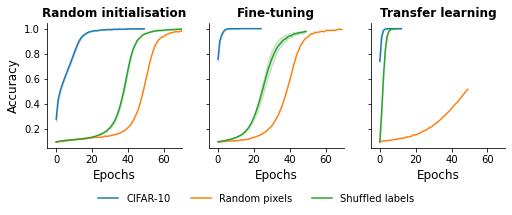

In [139]:
%%time
mod = 'vgg' #res
models = [f'{mod}_sim_rnd-pixels_upscaled_no_pre', f'{mod}_sim_rnd-pixels_upscaled_fine_tune',
          #f'{mod}_sim_rnd-pixels_large_no_pre', f'{mod}_sim_rnd-pixels_large_fine_tune',
#           'vgg_sim_random_large__no_pre', 'vgg_sim_random_large__fine_tune',
          f'{mod}_sim_cifar_upscaled__fine_tune', f'{mod}_sim_cifar_upscaled__no_pre', # add _ after upscaled for vgg
          f'{mod}_freeze_sim_rnd-pixels_upscaled_fine_tune', f'{mod}_freeze_sim_cifar_upscaled_fine_tune',
          f'{mod}_freeze_sim_rnd-labels_upscaled_fine_tune',# add _ after upscaled for vgg
          f'{mod}_sim_rnd-labels_upscaled_fine_tune', f'{mod}_sim_rnd-labels_upscaled_no_pre']#,
          #f'{mod}_freeze_sim_rnd-labels_upscaled_fine_tune']
          #, 'vgg_freeze_sim_random_large', 'vgg_sim_random_large__no_pre', 'vgg_sim_random_large__fine_tune']
         # These ones  above ^ are for the rnd-pixels large dataset
          #, 'vgg_freeze_sim_cifar_upscaled__no_pre', 'vgg_freeze_sim_random_large__no_pre']
cols = ['accuracy', 'data', 'epochs', 'freeze', 'weights', 'data_sizing_type', 'hidden_1', 'learning_rate']
df = get_results_from_model(models, cols, logs_format='full')
print(df[df['data'] == 'rnd-labels'][df['weights'].isnull()][df['hidden_1'] == 512]['learning_rate'].unique())

df['weights'] = df['weights'].map({'imagenet': 'ImageNet', None:'Xavier uniform'})
df['data'] = df['data'].map({'cifar': 'CIFAR-10','rnd-pixels': 'Random pixels',
                             'random': 'Random pixels', 'rnd-labels': 'Shuffled labels'})
df = df.rename(columns={'data': 'Dataset', 'weights': 'Weights'})

filter_freeze = df['freeze'].eq(True)
filter_finetune = df['freeze'].eq(False)
filter_rndpix = df['Dataset'].eq('Random pixels')
filter_cifar = df['Dataset'].eq('CIFAR-10')
filter_shuffled = df['Dataset'].eq('Shuffled labels')
filter_xavier = df['Weights'].eq('Xavier uniform')
filter_imagenet = df['Weights'].eq('ImageNet')
filter_freeze_data = [filter_freeze & filter_imagenet,
                      filter_finetune & filter_imagenet,
                      filter_finetune & filter_xavier]
filter_choices = ['Transfer learning', 'Fine-tuning', 'Random initialisation']
df['Weight type'] = np.select(filter_freeze_data, filter_choices)

df.loc[(df['Dataset'].eq('Random pixels')) & (df['data_sizing_type'].eq('large')), 'Dataset'] = 'Random pixels large'


curr_lr = 0.0005#0.01
epsilon = 0.0001
curr_hidden = 4096#1024

print(df['hidden_1'].unique())

df = df[df['epochs'] <= 70]
df = df[df['hidden_1'] == curr_hidden]
df = df[abs(df['learning_rate'] - curr_lr) < epsilon] 


fig, axes = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER, TEXT_WIDTH_PAPER/2.4) #(12,5)

sns.despine()



for wtype, ax in zip(df['Weight type'].unique(), axes):
    print(wtype)
    sns.lineplot(data=df[df['Dataset'].ne('Random pixels large')][df['Weight type'].eq(wtype)], y='accuracy', x='epochs', hue='Dataset',
                ax=ax, hue_order=['CIFAR-10','Random pixels', 'Shuffled labels'])
    ax.axes.set_xlabel('Epochs')
    ax.legend_.remove()
    ax.set_xlim(-5,70)
    ax.set_title(wtype)

axes[0].set_ylabel('Accuracy')
handles, labels = axes[0].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]

for a in fig.axes:
    a.tick_params(
    axis='both',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=True,
    top=False,
    left=True,
    labelbottom=True)
  

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
lgd = plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0.5,0), loc="lower center", 
                 bbox_transform=fig.transFigure, ncol=4)
plt.savefig(os.path.join(os.getcwd(), f'{mod}_pretraining_lr_{curr_lr}_hidden_{curr_hidden}_SPLIT_SMALL{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')

<h2> Generalisation to CIFAR-10-G (contours, line drawings, sillhouettes) </h2>
<h3> (Not in article, to appear in forthcoming PhD thesis) </h3>

In [13]:
data_dir = os.path.join(os.getcwd(), 'results', 'ood_gen','*')
data_files = [dfile for dfile in glob.glob(data_dir) if not os.path.isdir(dfile)] 
df = pd.DataFrame()
for dat_file in data_files:
    df_file = pd.read_csv(dat_file)
    df = df.append(df_file)

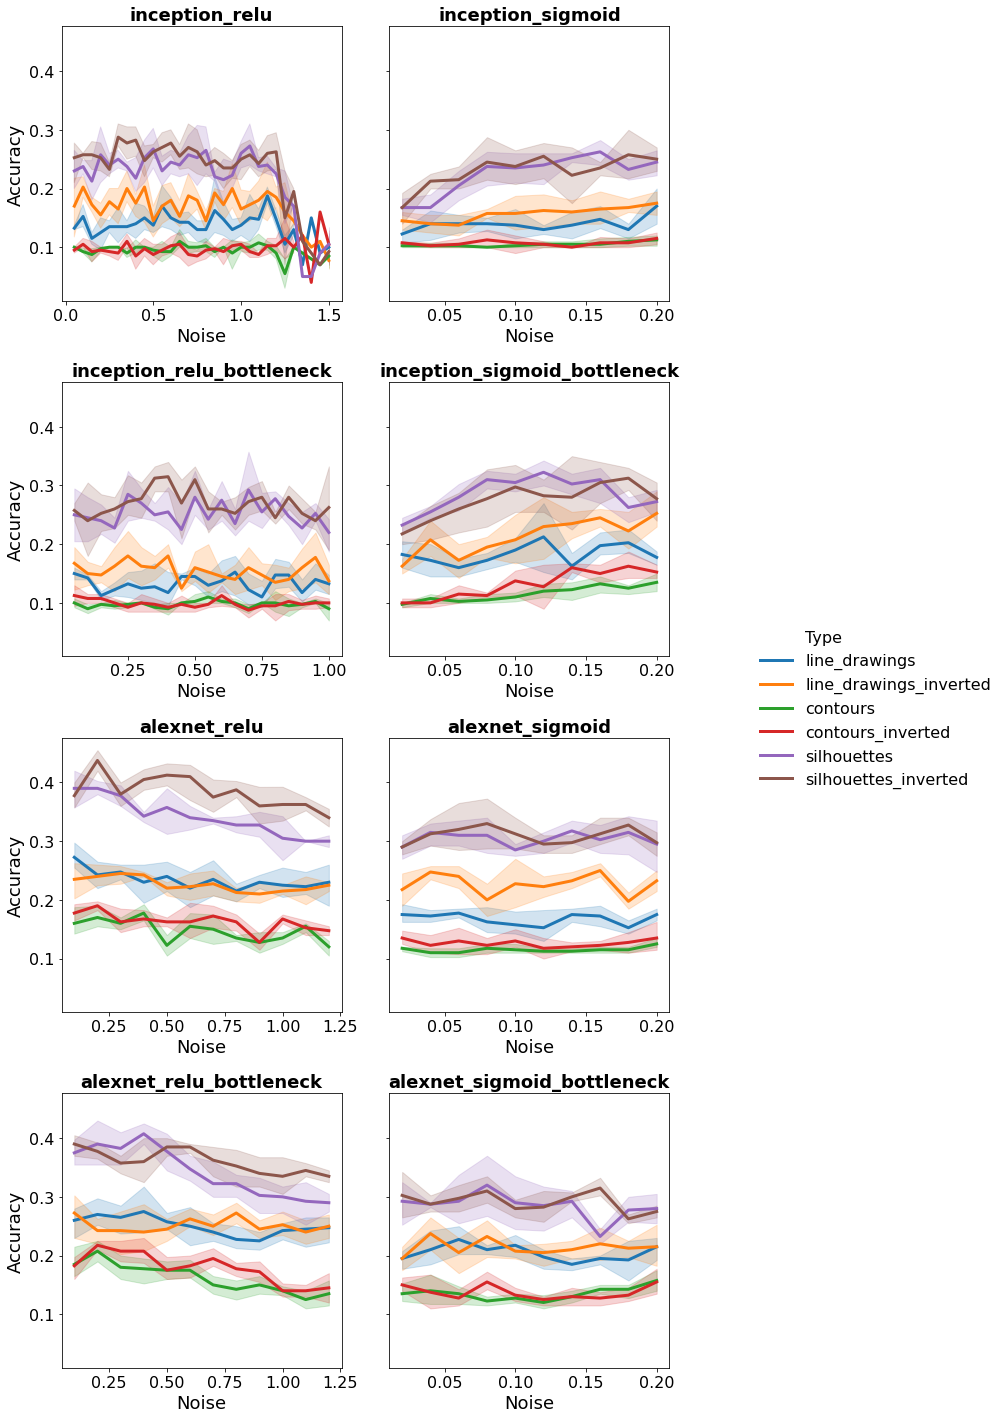

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharey=True)
fig.set_size_inches(10,20)
# sns.relplot(kind='line', hue='Type', x='Noise', y='Accuracy', col='Activation', row='Model', data=df[(df['Bottleneck'] == 'False')])
col_names = ['relu', 'sigmoid']
row_names = [['inc',False],['inc', True],['alx', False], ['alx', True]]
legend = False
for i in range(4):
    for j in range(2):
        if i == 3 and j == 1:
            legend = 'full'
        sns.lineplot(ax=axes[i,j], hue='Type', x='Noise', y='Accuracy', legend=legend,
             data=df[(df['Bottleneck'] == row_names[i][1]) & (df['Activation'] == col_names[j]) & (df['Model'] == row_names[i][0])])
        model_name = 'inception' if row_names[i][0] == 'inc' else 'alexnet'
        bneck = '_bottleneck' if row_names[i][1] == True else ''
        axes[i,j].set_title(f'{model_name}_{col_names[j]}{bneck}')

        if col_names[j] == 'relu':
            axes[i,j].set_xlim(-0.025, 1)

plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", 
                bbox_transform=fig.transFigure, ncol=1)
plt.savefig(os.path.join(os.getcwd(), f'generalisation_cifar10G_acc{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')

<h2>Replication of simulations in section 3.2 with <b>mobilenet </b> and <b>densenet</b></h2>

In [26]:
model_type = 'dense' # 'mobile' 

all_models = [f'{model_type}_ncurve_cifar', f'{model_type}_ncurve_rnd', f'{model_type}_ncurve_labels',
              f'{model_type}_ncurvesig_cifar', f'{model_type}_ncurvesig_rnd', f'{model_type}_ncurvesig_labels',
              f'{model_type}_bncurve_cifar', f'{model_type}_bncurve_rnd', f'{model_type}_bncurve_labels',
              f'{model_type}_bncurvesig_cifar', f'{model_type}_bncurvesig_rnd', f'{model_type}_bncurvesig_labels']
              
params = ['accuracy', 'noise', 'data', 'activation', 'bottleneck']

df = get_results_from_model(model_names=all_models, col_list=params, model_type=model_type)
df = df.rename(columns={'data':'Data type'})

Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.


[<matplotlib.lines.Line2D object at 0x7f30244063d0>, <matplotlib.lines.Line2D object at 0x7f302740f790>, <matplotlib.lines.Line2D object at 0x7f30244df0d0>, <matplotlib.lines.Line2D object at 0x7f3024406ad0>, <matplotlib.lines.Line2D object at 0x7f30244dfa10>, <matplotlib.lines.Line2D object at 0x7f3024444890>, <matplotlib.lines.Line2D object at 0x7f30243c0310>, [<matplotlib.lines.Line2D object at 0x7f30243c0310>]] ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck', 'Chance']


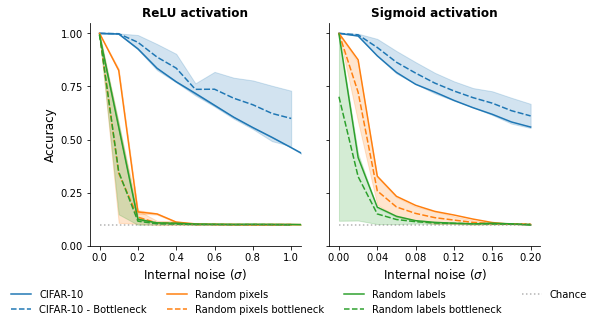

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER, TEXT_WIDTH_PAPER*0.6)
first = sns.lineplot(x='noise',y='accuracy',hue='Data type', style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='relu'],ax=ax[0],legend='full')#,style='Dataset'

chance_xy = [0, 0.6] if model_type=='mobile' else [0, 1]
chanceline = ax[0].plot(chance_xy,[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,label='Chance')

handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:-4]+[handles[-1]]
labels = labels[1:-4]+[labels[-1]]
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[2].get_c(), lw=handles[2].get_lw(), ls='--')]
handles = [x for pair in zip(handles, custom_lines) for x in pair]+[handles[-1]]#[handles[0], custom_lines[0], handles[1], custom_lines[1], handles[2]]
handles.append(chanceline)
labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck','Chance']

first.legend_.remove()
print(handles,labels)
plt.tight_layout()
plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4)#bbox_to_anchor=(1., 0.5), loc='center left')

lgd = sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='sigmoid'],ax=ax[1],legend=False)

if model_type == 'dense':
    ax[1].axes.set_xticks(np.linspace(0,0.2,6))
    ax[0].set_xlim(-0.05,1.05)
elif model_type == 'mobile':
    ax[1].axes.set_xticks(np.linspace(0,0.1,6))
    ax[0].axes.set_yticks(np.linspace(0,0.6,6))
    ax[0].set_xlim(-.025,0.525)
    ax[1].set_xlim(-.005, 0.105)

ax[0].axes.set_yticks(np.linspace(0,1,5))
ax[0].set_ylim(0,1.05)

ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Internal noise '+r'$(\sigma)$')
ax[1].set_xlabel('Internal noise '+r'$(\sigma)$')

ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

sns.despine()

chance_sig_xy = [0, 0.1] if model_type=='mobile' else [0, 0.2]
ax[1].plot(chance_sig_xy,[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,)

fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'constraints_only_train_{model_type}_{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


<h2>small-inception - 200 epochs accuracy and loss</h2>

In [142]:
all_models = ['inc-200epochs-ncurve-rnd', 'inc-200epochs-ncurve-labels',
              'inc-200epochs_ncurve-cifar', 'inc-200epochs_ncurvesig-cifar',
              'inc-200epochs_ncurvesig-labels', 'inc-200epochs_sig-lr_1e-2-rnd',
              'inc-200epochs_bncurve-cifar', 'inc-200epochs_bncurve-labels', 
              'inc-200epochs_bncurve-rnd', 'inc-200epochs_bncurvesig-labels',
              'inc-200epochs_bncurvesig-rnd','inc-200epochs_bncurvesig-cifar']
              
params = ['accuracy', 'noise', 'data', 'activation', 'bottleneck', 'epochs']

df = get_results_from_model(model_names=all_models, col_list=params, model_type='inc', logs_format='last')#'last')
df = df.rename(columns={'data':'Data type'})

Continuing without file.
Continuing without file.
Continuing without file.
Continuing without file.


/home/gx19122/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[<matplotlib.lines.Line2D object at 0x7fcd555ea1d0>, <matplotlib.lines.Line2D object at 0x7fcd556f7750>, <matplotlib.lines.Line2D object at 0x7fcd555ea6d0>, <matplotlib.lines.Line2D object at 0x7fcd55d66410>, <matplotlib.lines.Line2D object at 0x7fcd555eab90>, <matplotlib.lines.Line2D object at 0x7fcd555e5b50>, <matplotlib.lines.Line2D object at 0x7fcd55712d10>, [<matplotlib.lines.Line2D object at 0x7fcd55712d10>]] ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck', 'Chance']


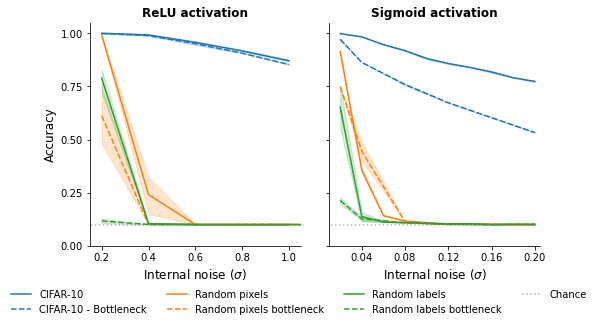

In [143]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER, TEXT_WIDTH_PAPER*0.6)
first = sns.lineplot(x='noise',y='accuracy',hue='Data type', style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='relu'][df['noise']>=0.2],ax=ax[0],legend='full')#,style='Dataset'
chanceline = ax[0].plot([0,1],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,label='Chance')

handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:-4]+[handles[-1]]
labels = labels[1:-4]+[labels[-1]]
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[2].get_c(), lw=handles[2].get_lw(), ls='--')]
# labels.append('Chance')
handles = [x for pair in zip(handles, custom_lines) for x in pair]+[handles[-1]]#[handles[0], custom_lines[0], handles[1], custom_lines[1], handles[2]]
handles.append(chanceline)
labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck', 'Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck','Chance']

first.legend_.remove()
print(handles,labels)
plt.tight_layout()
plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4)#bbox_to_anchor=(1., 0.5), loc='center left')

lgd = sns.lineplot(x='noise',y='accuracy',hue='Data type',style='bottleneck', hue_order=['cifar','rnd-gauss','rnd-labels'], data=df[df['activation']=='sigmoid'],ax=ax[1],legend=False)

ax[1].axes.set_xticks(np.linspace(0,0.2,6))
ax[0].set_ylim(0,1.05)
ax[0].axes.set_yticks(np.linspace(0,1,5))

ax[0].set_xlim(0.15, 1.05)
ax[1].set_xlim(0.01, 0.205)

ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Internal noise '+r'$(\sigma)$')
ax[1].set_xlabel('Internal noise '+r'$(\sigma)$')

ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

sns.despine()

ax[1].plot([0,0.2],[0.1,0.1],c=[0.5,0.5,0.5],linestyle=':',alpha=0.6,)

fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'constraints_200epochs_inc_{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


In [126]:
df_relu = df[(df['noise'].eq(0.6) & df['activation'].eq('relu'))]
df_sigmoid = df[(df['noise'].eq(0.14) & df['activation'].eq('sigmoid'))]
df_sigmoid =df_sigmoid[df_sigmoid['Data type'] != 'cifar']
df_relu =df_relu[df_relu['Data type'] != 'cifar']

(['rnd-gauss', 'rnd-labels'], [<matplotlib.lines.Line2D object at 0x7fcd557217d0>, <matplotlib.lines.Line2D object at 0x7fcd5535d890>])


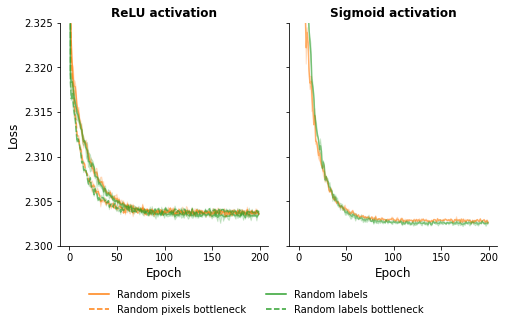

In [128]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER, TEXT_WIDTH_PAPER*0.6)

colour_set = [sns.color_palette()[1], sns.color_palette()[2]]
first = sns.lineplot(x='epochs',y='loss',hue='Data type', style='bottleneck',
                     hue_order=['rnd-gauss','rnd-labels'],
                     data=df_relu,ax=ax[0],legend='full',
                     palette=colour_set,
                     **{'alpha': 0.6})


handles, labels = ax[0].get_legend_handles_labels()
handles = handles[1:-3]
labels = labels[1:-3]
print((labels,handles))
custom_lines = [plt.Line2D([0], [0], color=handles[0].get_c(), lw=handles[0].get_lw(), ls='--'),
                plt.Line2D([0], [0], color=handles[1].get_c(), lw=handles[1].get_lw(), ls='--')]
handles = [x for pair in zip(handles, custom_lines) for x in pair]+[handles[-1]]#[handles[0], custom_lines[0], handles[1], custom_lines[1], handles[2]]
handles.append(chanceline)
labels = ['Random pixels', 'Random pixels bottleneck', 'Random labels', 'Random labels bottleneck']#,'Chance']

first.legend_.remove()
plt.tight_layout()
plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=2)#bbox_to_anchor=(1., 0.5), loc='center left')

lgd = sns.lineplot(x='epochs', y='loss', hue='Data type', style='bottleneck',
                   hue_order=['rnd-gauss','rnd-labels'], data=df_sigmoid, 
                   ax=ax[1],legend=False, palette=colour_set, **{'alpha': 0.5})

ax[0].set_ylim(2.3, 2.325)#(0,3)

ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')

ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

sns.despine()


fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'constraints_200epochs_inc_LOSS_ZOOM{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')


In [ ]:
model_type = 'alx'
all_models = [f'{model_type}-bneck-sweep', f'{model_type}-bnecksig-sweep']#, 'alx-bneck-sweep']
              
params = ['val_accuracy', 'data', 'activation', 'model', 'bottleneck', 'bneck_width', 'epochs']

df = get_results_from_model(model_names=all_models, col_list=params, model_type=model_type, logs_format='last')#'last')
df = df.rename(columns={'data':'Data type'})

In [190]:
df.loc[(df['bneck_width'].isnull()) & (df['model'].eq('inc')), 'bneck_width'] = 96#'96 \n (Baseline)'
df.loc[(df['bneck_width'].isnull()) & (df['model'].eq('alx')), 'bneck_width'] = 200#'200 \n (Baseline)'

[<matplotlib.collections.PathCollection object at 0x7f302218e0d0>, <matplotlib.collections.PathCollection object at 0x7f30226ebd90>] ['False', 'True']
[<matplotlib.collections.PathCollection object at 0x7f302218e0d0>, <matplotlib.collections.PathCollection object at 0x7f30226ebd90>] ['CIFAR-10', 'CIFAR-10 - Bottleneck']


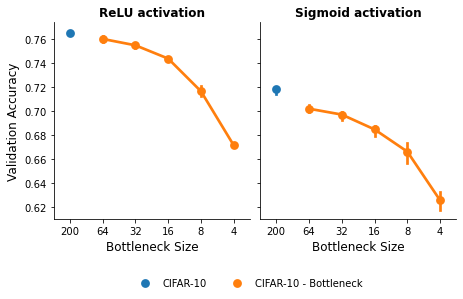

In [192]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, sharey=True)
fig.set_size_inches(TEXT_WIDTH_PAPER, TEXT_WIDTH_PAPER*0.6)
fig.subplots_adjust(wspace=0.05)
order_list = [200, 64, 32, 16, 8, 4] if model_type=='alx' else [96, 16, 8, 4, 2, 1]
first = sns.pointplot(x='bneck_width', y='val_accuracy', hue='bottleneck',
                     order=order_list,
                     data=df[df['activation']=='relu'],
                     ax=ax[0],legend='full')


handles, labels = ax[0].get_legend_handles_labels()
print(handles, labels)

labels = ['CIFAR-10', 'CIFAR-10 - Bottleneck']

first.legend_.remove()



print(handles,labels)
# plt.tight_layout()
lgd = sns.pointplot(x='bneck_width', y='val_accuracy', hue='bottleneck',
                     order=order_list,
                     data=df[df['activation']=='sigmoid'],
                     ax=ax[1],legend=False)


plt.legend(handles=handles, labels=labels ,bbox_to_anchor=(0.5,0), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=2)#bbox_to_anchor=(1., 0.5), loc='center left')


ax[0].set_ylabel('Validation Accuracy')
ax[1].set_ylabel('')
ax[0].set_xlabel('Bottleneck Size')
ax[1].set_xlabel('Bottleneck Size')


ax[0].set_title('ReLU activation')
ax[1].set_title('Sigmoid activation')

sns.despine()

fig.subplots_adjust(bottom=0.25)

plt.savefig(os.path.join(os.getcwd(), f'bneck_size_{model_type}_{SAVE_EXT}'),
            bbox_extra_artists=(lgd,), bbox_inches='tight')
